# Project: Advanced Lane Finding

## Import Packages

In [18]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Camera Calibration

### 1.Import calibration images 

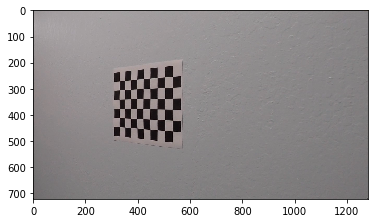

In [24]:
images = glob.glob('camera_cal/calibration*.jpg')

# sample image
img = cv2.imread(images[3])
plt.imshow(img)
nx = 9
ny = 6



### 2. Find corners and correct distortion

In [29]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        '''if idx ==3:
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)'''
        #plt.imshow(img)
        #plt.pause(0.5)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(dist)



[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259867]]
